In [1]:
import re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NLTK
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
lmtz = WordNetLemmatizer()


def lemmatize(word):
    if word.startswith('#'):
        return word
    
    lemma = lmtz.lemmatize(word, 'v')
    if lemma == word:
        lemma = lmtz.lemmatize(word, 'n')
    return lemma


def strip_punc(s):
    if s[0] == '#':
        return s
    return ''.join([c for c in s if c.isalpha()])

### Stop words

In [3]:
stop_words = [strip_punc(w) for w in stopwords.words('english')]
stop_words.extend([
    'i',
    'u',
    'r',
    'im',
    'cant',
    'would',
    'family',
    'domestic',
    'violence',
    'australia',
    'australian',
    'dv',
    'fv',
    'wa',
    'via',
    'today',
    'thing',
    'make',
    'talk',
    'due',
    'day',
    'month',
    'find',
    'show',
    'put',
    'part',
    'time',
    'yeah',
    'deal',
    'big',
    'level',
    'focus',
    'theyre',
    'list',
    'top',
    'give',
    'situation',
    'lot',
    'hold',
    'number',
    'include',
    'form',
    'back',
    'involve',
    'link',
    'real'
])

### Data

In [5]:
import configparser
import warnings
from pymongo import MongoClient

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

client = MongoClient(host, int(port))
db = client['mediacloud']

col_names = [
    'dv', 
    'fv',
    'dv-fv'
]

In [7]:
data = []

for col_name in col_names:
    for record in db[col_name].find():
        if '2018' in record['publish_date']:
            if record['text']:
                data.append(record['text'])
        
print(len(data))

5699


### Preprocessing

In [8]:
set_cleaned_sent = set()
data_lemmatized = []
data_filtered = []

for i, sent in enumerate(data):
    
    cleaned_sent = ''
    for token in sent.split():
        
        # Cleaning
        if token[0] in ['#','@','$','%','^','&','*'] or token.startswith('http'):
            continue

        # Remove puctuations, lower case
        token = strip_punc(token.lower())
        
        # Lemmatize
        lemma = lemmatize(token)

        if lemma and lemma not in stop_words:
            cleaned_sent += lemma + ' '
    
    cleaned_sent = cleaned_sent.strip()
    
    # Check for duplicates
    if cleaned_sent and cleaned_sent not in set_cleaned_sent:
        set_cleaned_sent.add(cleaned_sent)
        data_lemmatized.append(cleaned_sent.split())
        data_filtered.append(sent)
        
    if i % 100 == 0:
        print(i, end=' ')

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 

In [9]:
len(data_lemmatized)

5420

### Creating Bigram and Trigram Models

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_lemmatized, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_lemmatized], threshold=100)  

# Faster way to get a Tweet clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [13]:
data_lemmatized = make_bigrams(data_lemmatized)

### Create the Dictionary and Corpus needed for Topic Modeling

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(data_lemmatized[:1])

[['come', 'new', 'year', 'resolution', 'bathurst', 'improve', 'health', 'people', 'come', 'surprise', 'popular', 'answer', 'question', 'whats', 'new', 'year', 'resolution', 'statistic', 'around', 'world', 'often', 'favour', 'resolution', 'mayor_graeme', 'hanger', 'one', 'bathurst', 'want', 'health', 'resolution', 'old', 'traditional', 'one', 'lose', 'bite', 'weight', 'get', 'fit', 'apple', 'keep', 'doctor', 'away', 'say', 'also', 'hop', 'spend', 'year', 'grandchild', 'weve', 'get', 'try', 'catch', 'say', 'member', 'bathurst', 'paul_toole', 'also', 'jump', 'board', 'health', 'fitness', 'bandwagon', 'new', 'year', 'resolution', 'get', 'fitter', 'say', 'mr', 'toole', 'also', 'want', 'difference', 'community', 'new', 'year', 'set', 'ambitious', 'careerrelated', 'goal', 'ive', 'set', 'goal', 'minimum', 'one', 'fund', 'announcement', 'bathurst', 'electorate', 'say', 'lifeline_central', 'west', 'executive_director', 'alex_ferguson', 'say', 'lifeline', 'good', 'year', 'across', 'board', 'resol

### Building LDA Mallet Model
Mallet’s version of LDA often gives a better quality of topics.
Num of topics = 20 at this step.

In [15]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'input/mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

### Optimal number of topics for LDA
Build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        print(str(len(model_list)-1)+'-'+str(num_topics),end=' ')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#### Topic coherence provide a convenient measure to judge how good a given topic model is.

In [18]:
# Takes a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=14, step=2)

0-5 1-7 2-9 3-11 4-13 

In [ ]:
# ml2, cv2 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=15, limit=20, step=2)
# model_list.extend(ml2)
# coherence_values.extend(cv2)

# Graphs

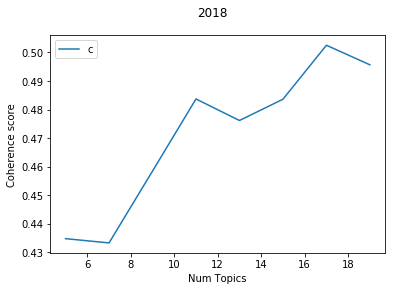

In [21]:
limit=20; start=5; step=2;
x = range(start, limit, step)
plt.figure().suptitle('2018')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Evaluation

In [29]:
pyLDAvis.enable_notebook()
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_list[0])
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.026665  0.001703       1        1  22.834606
4      0.039576 -0.182416       2        1  21.380403
3      0.245932 -0.122121       3        1  19.147713
1     -0.330622 -0.038670       4        1  18.612947
0      0.071779  0.341504       5        1  18.024331, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
187    Default  12222.000000        police  12222.000000  30.0000  30.0000
207    Default  16409.000000         woman  16409.000000  29.0000  29.0000
29     Default   9049.000000     community   9049.000000  28.0000  28.0000
469    Default   7567.000000       service   7567.000000  27.0000  27.0000
159    Default   5987.000000         court   5987.000000  26.0000  26.0000
475    Default   6068.000000       support   6068.000000  25.0000  25.0000
95     Default  11026.000000        people  11026.000000  24.0000  24.0000
180    Default   4842.000000           man   4842.000000  23.0000  23.0000
443    Default   5229.000000    government   5229.000000  22.0000  22.0000
182    Default   3749.000000           men   3749.000000  21.0000  21.0000
155    Default   3058.000000        charge   3058.000000  20.0000  20.0000
748    Default   3061.000000       program   3061.000000  19.0000  19.0000
743    Default   3326.000000      per_cent   3326.000000  18.0000  18.0000
84     Default   8182.000000            mr   8182.000000  17.0000  17.0000
297    Default   3297.000000         crime   3297.000000  16.0000  16.0000
684    Default   2903.000000         abuse   2903.000000  15.0000  15.0000
390    Default   4254.000000        report   4254.000000  14.0000  14.0000
174    Default   2438.000000      incident   2438.000000  13.0000  13.0000
784    Default   2264.000000       assault   2264.000000  12.0000  12.0000
140    Default   2229.000000       yearold   2229.000000  11.0000  11.0000
459    Default   3087.000000       provide   3087.000000  10.0000  10.0000
643    Default   2330.000000           law   2330.000000   9.0000   9.0000
1415   Default   2990.000000       officer   2990.000000   8.0000   8.0000
206    Default   4397.000000        victim   4397.000000   7.0000   7.0000
706    Default   3585.000000    experience   3585.000000   6.0000   6.0000
47     Default   2525.000000          fund   2525.000000   5.0000   5.0000
572    Default   1881.000000       offence   1881.000000   4.0000   4.0000
673    Default   3908.000000         state   3908.000000   3.0000   3.0000
1799   Default   2162.000000         event   2162.000000   2.0000   2.0000
676    Default   1898.000000        system   1898.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
695     Topic5    297.417787       college    297.417787   1.7134  -6.7815
830     Topic5    396.557049        season    397.774032   1.7104  -6.4938
1126    Topic5    286.536648    ambassador    286.536648   1.7134  -6.8188
5994    Topic5    281.700587  rugby_league    281.700587   1.7134  -6.8358
4716    Topic5    279.282556         coach    279.282556   1.7134  -6.8444
1302    Topic5    274.446494      football    274.446494   1.7134  -6.8619
1799    Topic5   1916.289399         event   2162.142366   1.5927  -4.9185
497     Topic5    738.708405          john    808.605142   1.6230  -5.8718
503     Topic5    973.257392          park   1109.002454   1.5829  -5.5960
1590    Topic5    696.392867           win    787.708092   1.5902  -5.9308
3076    Topic5    511.413511       weekend    575.225293   1.5959  -6.2395
21497   Topic5    495.696311        gympie    557.187665   1.5965  -6.2707
1179    Topic5    486.024188        career    545.656340   1.5977  -6.2904
717     Topic5    824.548498         great   1131.502521   1.3970  -5.7618
20      Topic5   1140.101516      business   1831.7801

In [358]:
pyLDAvis.save_html(vis, 'output/html/2014_13_clusters.html')

### Find the most representative document for each topic

In [22]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [ ]:
# Finding the dominant topic in each Tweet


def format_topics_sentences(ldamodel, corpus=corpus, texts=data_filtered):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_filtered)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



In [ ]:
# # Show
len(df_dominant_topic)

### Compute dominant topic for each Tweet

In [ ]:
# Group top 40 Tweets under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(40)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# # Format
# sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

## Most dominant topics and number of documents for each:

In [ ]:
# Number of Documents for Each Topic
series_topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

idx = []
topic_counts = []
keywords = []
topic_contributions = []

for (i, count) in series_topic_counts.iteritems():
    idx.append(int(i))
    keywords.append(", ".join([word for word, _ in optimal_model.show_topic(int(i))]))
    topic_counts.append(count)
    topic_contributions.append(str(round(100*count/series_topic_counts.sum(), 2))+'%')
    
df_dominant_topics = pd.DataFrame.from_dict({
    'Dominant_Topic_Num': idx,
    'Topic_Keywords': keywords, 
    'Num_Documents': topic_counts, 
    'Perc_Documents': topic_contributions
})

# Show
pd.options.display.max_colwidth = 100
df_dominant_topics.set_index('Dominant_Topic_Num', inplace=True)
df_dominant_topics

# DF to Excel

In [ ]:
from pandas import ExcelWriter

writer = ExcelWriter('output/2014/data/2014_13_clusters.xlsx')
new_df = df_dominant_topics.copy()
new_df.index += 1
new_df.to_excel(writer,'topic_rank')

for topic_no in range(13):
    new_df = sent_topics_sorteddf_mallet.iloc[topic_no*40:((topic_no+1)*40),[0,4]]
    new_df.set_index('Document_No', inplace=True)
    
    replied_texts = []
    for i, row in new_df.iterrows():
        if replied_ids[indices[i]]:
            try:
                text = api.get_status(replied_ids[indices[i]], tweet_mode='extended').full_text
                replied_texts.append(text)
            except:
                replied_texts.append('')
        else:
            replied_texts.append('')
            
    new_df['In_Reply_To'] = replied_texts
    
    new_df.reset_index(inplace=True)
    new_df.drop(['Document_No'], axis=1, inplace=True)
    new_df.to_excel(writer,'topic_'+str(topic_no+1))
    
writer.save()